In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
training_data = pd.read_parquet('C:/Users/nguye/Downloads/BTCUSDT/')
labels = pd.read_parquet('C:/Users/nguye/Downloads/LABEL_BTCUSDT/')
labels.drop(columns="SYMBOL", inplace=True)
join_data = training_data.join(labels, how='left')
training_data.index = pd.to_datetime(training_data.index, unit='ms')
labels.index = pd.to_datetime(labels.index, unit='ms')


In [10]:
full_data = training_data.join(labels, how='left')
# labeled_data = training_data.join(labels, how='right')
labeled_data = training_data.join(labels)
labeled_data.dropna(inplace=True)

## Calculate R and V of data

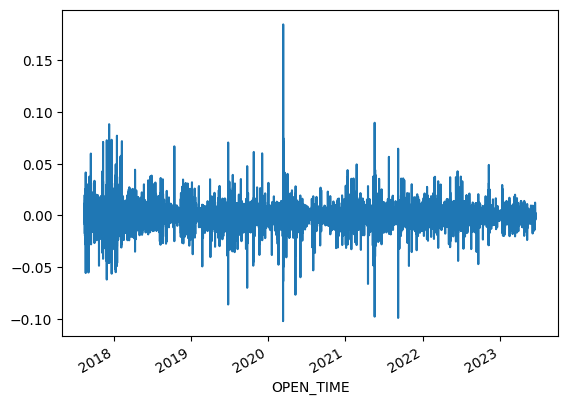

<Axes: xlabel='OPEN_TIME'>

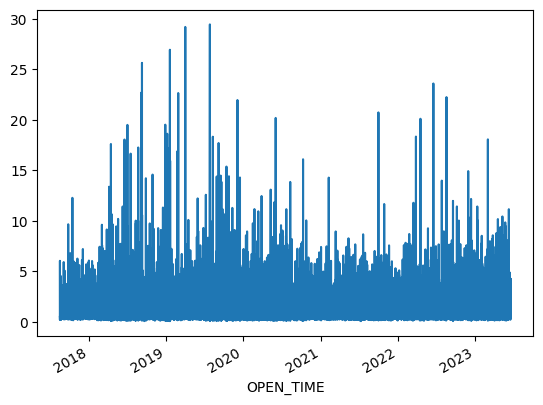

In [11]:
full_data['RETURN_RATE'] = (
    full_data['CLOSE'] - full_data['OPEN']) / full_data['OPEN']

std_backward = full_data['CLOSE'].rolling(19).std()
# rooling backward
std_forward = full_data['CLOSE'].rolling(19).std().shift(-6)
std_ratio = std_forward / std_backward

full_data['V'] = std_ratio

full_data['RETURN_RATE'].plot.line()
plt.show()
full_data['V'].plot.line()


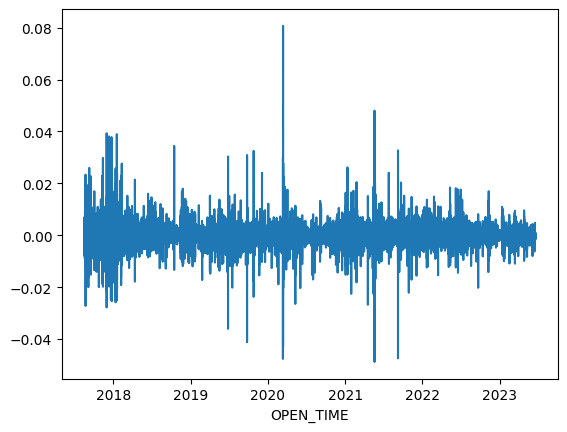

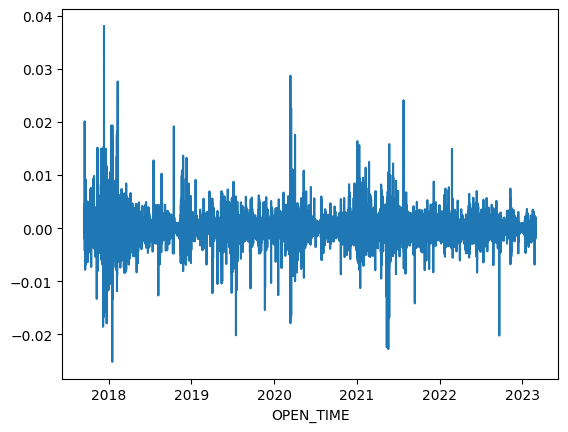

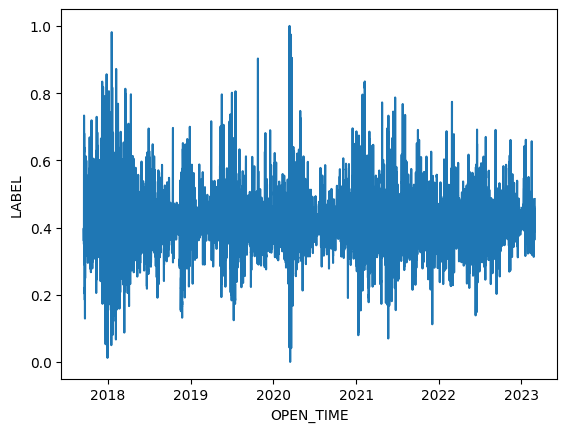

(612386,) (47662,)


In [12]:
y = full_data['RETURN_RATE'] / np.sqrt(full_data['V']) / 2


y_for_label = y.loc[labeled_data.index]
sns.lineplot(data=y)
plt.show()
sns.lineplot(data=y_for_label)
plt.show()
sns.lineplot(data=labeled_data['LABEL'])
plt.show()
print(y.shape, labeled_data['LABEL'].shape)


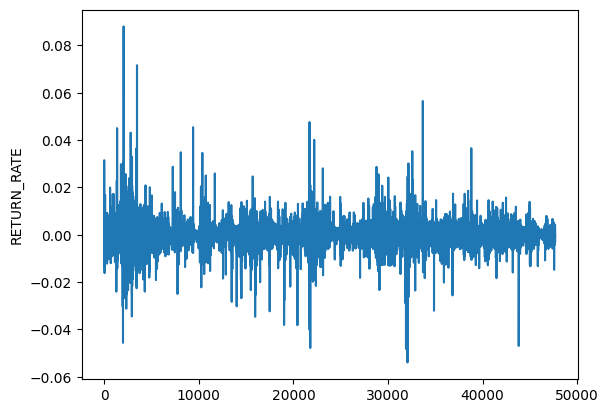

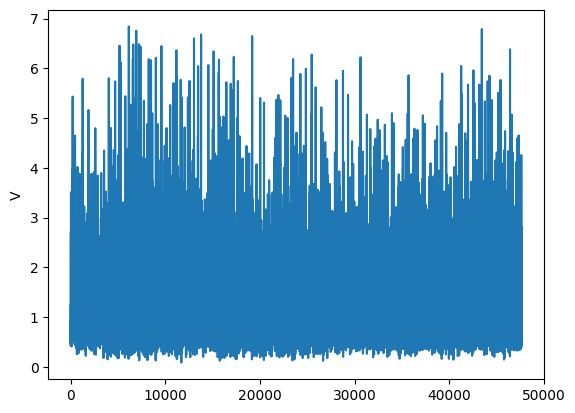

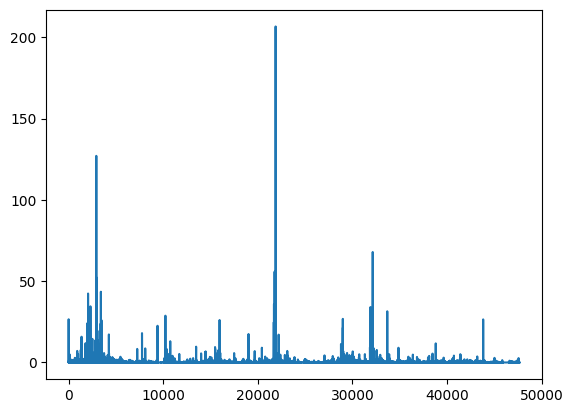

In [13]:
p_bm = (y_for_label**2) / (labeled_data['LABEL']**2)
p_bm[p_bm == np.inf]=0
# sns.lineplot(data=p_bm)
# plt.show()
# sns.lineplot(full_data['V'].loc[labeled_data.index])
# plt.show()
# sns.lineplot(full_data['RETURN_RATE'].loc[labeled_data.index])

X = full_data[['V', 'RETURN_RATE']].loc[labeled_data.index].reset_index(drop=True)
y = p_bm.reset_index(drop=True)*10000
y.describe()
X.describe()
X['RETURN_RATE'][X['RETURN_RATE'] > 4] = 4
X['RETURN_RATE'][X['RETURN_RATE'] < -4] = -3
X['V'][X['V'] > 7] = X['V'].mean()
sns.lineplot(data=X['RETURN_RATE'])
plt.show()
sns.lineplot(data=X['V'])
plt.show()
sns.lineplot(data=y)
plt.show()


In [14]:
y[y>20] =20

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=10)

# model = RandomForestRegressor(n_estimators=120, random_state=10,verbose=0,max_depth=12)

# model.fit(X_train, y_train)





In [16]:
# # public_test_pred = p_1_3['RETURN_RATE'] / np.sqrt(full_data['V']) / 2
# p_1_3['P_BM'] = test1
# public_test_pred = p_1_3['RETURN_RATE'] / np.sqrt(p_1_3['V']*p_1_3['P_BM']) / 2
# public_test_pred

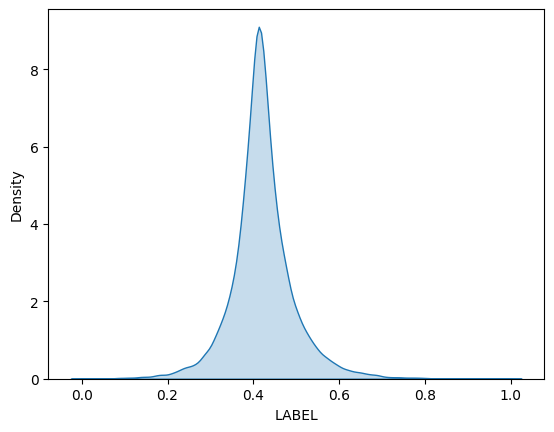

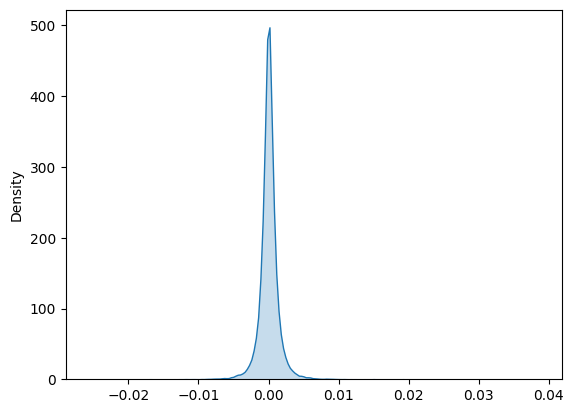

In [17]:
sns.kdeplot(data=labeled_data['LABEL'],fill=True)
# sns.kdeplot(y_for_label,fill=True)
# plt.legend(['LABEL', 'RETURN_RATE'])
# plt.xlim(-1, 1)
plt.show()
sns.kdeplot(y_for_label,fill=True)
plt.show()

In [18]:
labeled_data['LABEL'].describe()

count    47662.000000
mean         0.420557
std          0.074462
min          0.000000
25%          0.385336
50%          0.416168
75%          0.451782
max          1.000000
Name: LABEL, dtype: float64

# Trainning data

In [89]:
X = full_data.loc[labeled_data.index[(labeled_data.index>='2020-01-01') & (labeled_data.index<'2022-08-01')]]
y = X['LABEL']
X.drop(columns=['YEAR_AND_MONTH','LABEL','OPEN','CLOSE','QUOTE_ASSET_VOLUME','TAKER_BUY_BASE_ASSET_VOLUME','TAKER_BUY_QUOTE_ASSET_VOLUME'], inplace=True)
X

,HIGH,LOW,VOLUME,NUMBER_OF_TRADES,RETURN_RATE,V
OPEN_TIME,,,,,,
2020-01-01 00:00:00,7196.25,7178.64,95.509133,1127,-0.002149,1.398784
2020-01-01 01:00:00,7185.86,7175.71,30.163076,596,0.000950,1.445942
2020-01-01 02:00:00,7223.37,7214.09,62.727497,809,0.000240,0.930241
2020-01-01 03:00:00,7245.00,7230.25,87.259123,879,-0.001012,0.767176
2020-01-01 04:00:00,7229.72,7223.93,64.682238,951,0.000496,1.006652
...,...,...,...,...,...,...
2022-07-31 19:00:00,23909.02,23700.37,1119.221810,28292,0.006447,0.989036
2022-07-31 20:00:00,23892.43,23833.68,518.972810,16017,0.001233,0.312448
2022-07-31 21:00:00,23827.25,23795.05,251.615420,9515,0.000211,0.966001


In [90]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=12)
model = RandomForestRegressor(n_estimators=140, random_state=12,verbose=1,max_depth=15,min_samples_leaf=3)
# model.fit(X_train, y_train)

In [91]:
model.fit(X,y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:   38.1s finished


RandomForestRegressor(max_depth=15, min_samples_leaf=3, n_estimators=140,
                      random_state=12, verbose=1)

# Predict

In [104]:
# Create a dataframe and resample to hourly data
t = pd.date_range(start='2021-12-31', end='2023-03-03', freq='H')
public_test_train = full_data.resample('H').last().loc[t]

# Drop the columns that are not needed
public_test_train.drop(columns=['YEAR_AND_MONTH','LABEL','OPEN','CLOSE','QUOTE_ASSET_VOLUME','TAKER_BUY_BASE_ASSET_VOLUME','TAKER_BUY_QUOTE_ASSET_VOLUME'], inplace=True)
# Fill the missing values
public_test_train.fillna(method='bfill', inplace=True)

# index OPENTIME 
idx = t.astype(np.int64) // 10**6


In [93]:
public_test_pred = model.predict(public_test_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    0.1s finished


In [94]:
public_test= pd.DataFrame({'OPEN_TIME':idx, 'PREDICTION':public_test_pred})
public_test.to_csv('C:/Users/nguye/Downloads/public_test1.csv', index=False)

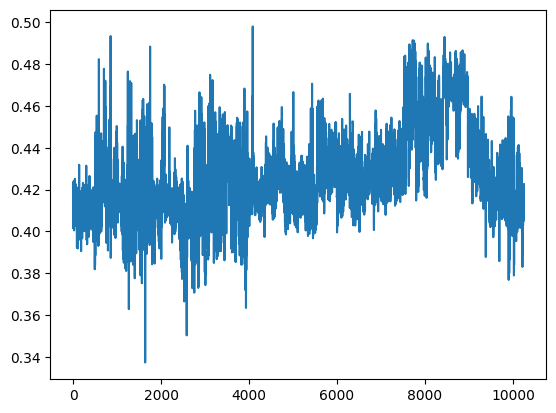

<Axes: ylabel='Density'>

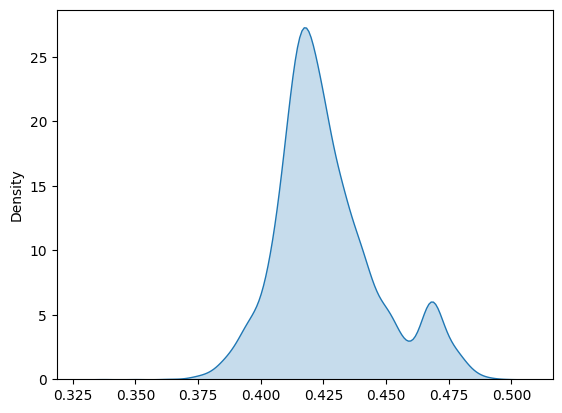

In [95]:
sns.lineplot(data=public_test_pred)
plt.show()
sns.kdeplot(data=public_test_pred,fill=True)

In [101]:
public_test_pred

array([0.4215457 , 0.40152832, 0.40873509, ..., 0.41551208, 0.41321331,
       0.42259282])

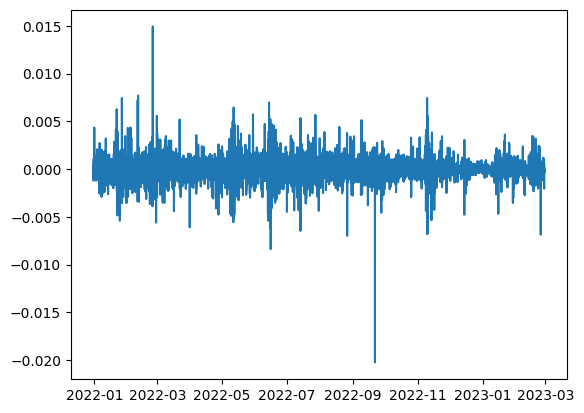

<Axes: ylabel='LABEL'>

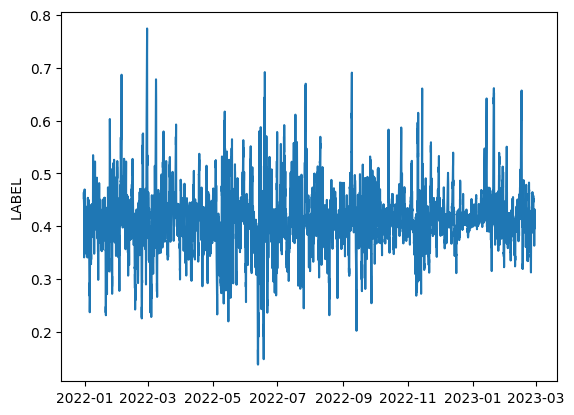

In [108]:
t1 = pd.date_range(start='2021-12-31', end='2023-02-28', freq='H')
# sns.kdeplot(data=labeled_data['LABEL'].loc[t1])
sns.lineplot(data=y_for_label.loc[t1])
plt.show()
sns.lineplot(data=labeled_data['LABEL'].loc[t1])

In [97]:
labels
# Tính từ đầu 2020 đến tháng 7 năm 2022

,LABEL
OPEN_TIME,
2017-09-16 10:00:00,0.393885
2017-09-16 11:00:00,0.390215
2017-09-16 12:00:00,0.360434
2017-09-16 13:00:00,0.398650
2017-09-16 14:00:00,0.451718
...,...
2023-02-28 19:00:00,0.448246
2023-02-28 20:00:00,0.470401
2023-02-28 21:00:00,0.468764


In [98]:
# from joblib import dump, load
# dump(model, 'model_nestquant_v1.joblib')

In [99]:
# loaded_model = load('model_nestquant_v1.joblib')


In [100]:
# loaded_model